Updated: 12/8/2020

Scraping Craigslist's rental section to get accurate representation of the prices and square footage of 1 bedrooms throughout different Chicago neighorhoods.

In [8]:

#import get to call a get request on the site
from requests import get

#get the 1st page of the chicago housing prices 
#get rid of posts without a pic using their filter
response = get('https://chicago.craigslist.org/search/chc/apa?hasPic=1&availabilityMode=0')

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [9]:
#get first post
post_one = posts[0]

In [10]:
#price of 1st post
post_one_price = post_one.a.text
#remove comma from listing. Need to do later for all the posts
#post_one_price = post_one.a.text.replace(',', '')
post_one_price.strip()

'$1,500'

In [11]:
#get the time of the post in datetime format
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [12]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [13]:
#execute multiple statements per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element
post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]
post_one_num_bedrooms

post_one_sqft = post_one.find('span', class_ = 'housing')
post_one_sqft

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft
#post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

'2br'

<span class="housing">
                    2br -
                </span>

IndexError: list index out of range

In [15]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from there

post_one_hood = posts[0].find('span', class_='result-hood').text

In [16]:
#build out the loop
from time import sleep
import re
##this will allow us to scrape without getting blocked by craigslist
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://chicago.craigslist.org/search/chc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, the comma 
            #and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "").replace(",",""))
            #post_price = int(post.a.text.strip().replace(',', '')
            post_prices.append(post_price)
                        
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [17]:
import pandas as pd

ch_apts = pd.DataFrame({'Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post_Title': post_title_texts,
                       'Num_Bedrooms': bedroom_counts,
                        'Sqft': sqfts,
                        'URL': post_links,
                       'Price': post_prices})
print(ch_apts.info())
ch_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Posted        2626 non-null   object 
 1   Neighborhood  2626 non-null   object 
 2   Post_Title    2626 non-null   object 
 3   Num_Bedrooms  2314 non-null   object 
 4   Sqft          624 non-null    float64
 5   URL           2626 non-null   object 
 6   Price         2626 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 143.7+ KB
None


,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-08 12:56,(CHICAGO),AVAILABLE NOW!!!!-3802 N SEELEY-2S 2 BED/ 1 BATH,2,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1500
1,2020-12-08 12:55,(Edgewater/ Chicago),1 bedroom in Edgewater neighborhood 1ST MONTH ...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,875
2,2020-12-08 12:50,(South Loop),"SOUTH LOOP! AMAZING LOFT STYLE Jr 1 bed WD, hd...",1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1170
3,2020-12-08 12:50,(Pilsen/UIC Area/ Pink Line),RENOVATED Pilsen 1 Bed with in-unit washer/dryer,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400
4,2020-12-08 12:48,(CHICAGO),AVAILABLE NOW!!!!-HOT SOUTHPORT CORRIDOR LOCAT...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1495
5,2020-12-08 12:44,(On 70th St. and Crandon),2209-2211 E. 70th St: HUGE 2BR/1BA Apartment,2,1000.0,https://chicago.craigslist.org/chc/apa/d/70th-...,1175
6,2020-12-08 12:42,(Uptown/Andersonvile),1 bedroom in west uptown/andersonvile 1ST MONT...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,895
7,2020-12-08 12:41,(Pilsen),Pilsen apartment for rent,2,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,950
8,2020-12-08 12:40,(CHICAGO),HOT SOUTHPORT CORRIDOR LOCATION-1417 W CORNELI...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1495
9,2020-12-08 12:40,(South Shore),2209 E 70th St - LOVELY GARDEN UNIT 1BD/1BTH,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,800


In [ ]:
########################DATA CLEANING


In [18]:
#Deleting duplicate postings bc people spam Craigslist with fake postings
# the duplicate postings are most likely spam
#Displays uniqe posts
ch_apts = ch_apts.drop_duplicates(subset='URL')
len(ch_apts.drop_duplicates(subset='URL'))

#converts the # of bedrooms to a float (since np.nan is a float too)
ch_apts['Num_Bedrooms'] = ch_apts['Num_Bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to work with it
from datetime import datetime
ch_apts['Posted'] = pd.to_datetime(ch_apts['Posted'])

#Checking neighborhoods that there are with ch_apts['neighborhood'].unique()
#Seeing that allowed me to know what I needed to deal with in terms of cleaning those

#remove the parenthesis from the left and right of the neighborhoods
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#titlecase them
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
########################
#####################

#UPDATE
###################
########################
#remove whitespaces
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.strip())

101

In [19]:
### EXPLORATORY DATA ANALYSIS
#Checking first record
ch_apts.head(1)

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-08 12:56:00,Chicago,AVAILABLE NOW!!!!-3802 N SEELEY-2S 2 BED/ 1 BATH,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1500


In [22]:
#Checking unique neighborhood names
ch_apts.Neighborhood.unique()

#removing listings that have addresses as listings
ch_apts = ch_apts[(ch_apts.Neighborhood != 'On 70Th St. And Crandon')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1317 W. 18Th Street | #1F | Chicago, Il')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1550 S Hamlin  North Lawndale')]
ch_apts = ch_apts[(ch_apts.Neighborhood != 'Augusta Blvd At California Ave')]
ch_apts = ch_apts[(ch_apts.Neighborhood != 'All Pets')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3144 W 39Th Pl')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1550 S Hamlin  North Lawndale')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '8901 S Loomis - Brainerd Senior Center')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '737 E 69Th')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '737 E 69Th')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3144 W 39Th Pl, Chicago Il.')]






#(ch_apts.Neighborhood != 10)]

ch_apts.Neighborhood.unique()


array(['Chicago', 'Edgewater', 'South Loop', 'Pilsen', 'Uptown',
       'South Shore', 'North Kenwood', 'Bucktown', 'Little Italy',
       'Rogers Park', 'Lincoln Park', 'West Lakeview', 'Lakeview',
       'Buena Park', 'Chicago & Lasalle', 'River North', 'Irving Park',
       'Chicago, Illinois', 'Fulton Market, Chicago', 'Lincoln Square',
       'Andersonville', 'All Pets', 'Hyde Park',
       'South Loop Mccormick Square', 'Evanston', 'Jefferson Park',
       'Lakeview, Chicago', 'Sheridan Park', 'Roscoe Village',
       'Gold Coast', 'Logan Square', 'Auburn Gresham', 'Glenview',
       'Wrigleyville', 'Ukrainian Village', 'Chicago - Uptown',
       'Midway Area', 'Chicago Prime Bridgeport', 'Beacon & Wilson',
       'Chicago, Il'], dtype=object)

array(['Chicago', 'Edgewater', 'South Loop', 'Pilsen', 'Uptown',
       'South Shore', 'North Kenwood', 'Bucktown', 'Little Italy',
       'Rogers Park', 'Lincoln Park', 'West Lakeview', 'Lakeview',
       'Buena Park', 'Chicago & Lasalle', 'River North', 'Irving Park',
       'Chicago, Illinois', 'Fulton Market, Chicago', 'Lincoln Square',
       'Andersonville', 'Hyde Park', 'South Loop Mccormick Square',
       'Evanston', 'Jefferson Park', 'Lakeview, Chicago', 'Sheridan Park',
       'Roscoe Village', 'Gold Coast', 'Logan Square', 'Auburn Gresham',
       'Glenview', 'Wrigleyville', 'Ukrainian Village',
       'Chicago - Uptown', 'Midway Area', 'Chicago Prime Bridgeport',
       'Beacon & Wilson', 'Chicago, Il'], dtype=object)

In [23]:
#Correcting neighborhood names
for Post_Title in ch_apts:
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('avon'), 'Neighborhood'] = 'Avondale'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Avon'), 'Neighborhood'] = 'Avondale'  
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('China'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('china'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gold Coast'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gold'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little Village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Marquette Park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('marquette park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Mount Greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('mount greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Old Town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('old town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River North'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river north'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River West'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river west'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rodgers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Roscoe Village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('roscoe village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigley'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ukrainian Village'), 'Neighborhood'] = 'Ukrainian Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ukrainian village'), 'Neighborhood'] = 'Ukrainian Village'

ch_apts

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-08 12:56:00,Chicago,AVAILABLE NOW!!!!-3802 N SEELEY-2S 2 BED/ 1 BATH,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1500
1,2020-12-08 12:55:00,Edgewater,1 bedroom in Edgewater neighborhood 1ST MONTH ...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,875
2,2020-12-08 12:50:00,South Loop,"SOUTH LOOP! AMAZING LOFT STYLE Jr 1 bed WD, hd...",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1170
3,2020-12-08 12:50:00,Pilsen,RENOVATED Pilsen 1 Bed with in-unit washer/dryer,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400
4,2020-12-08 12:48:00,Chicago,AVAILABLE NOW!!!!-HOT SOUTHPORT CORRIDOR LOCAT...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1495
...,...,...,...,...,...,...,...
94,2020-12-08 09:17:00,Chicago,Amazing One Bedroom Apartments @Willard Squ...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,934
95,2020-12-08 09:16:00,Lakeview,521 W. Brompton in Lakeview: Studio - Free Hea...,NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1015
97,2020-12-08 09:15:00,Lakeview,517 W. Brompton in Lakeview: Studio- Free Heat...,NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1055
98,2020-12-08 09:14:00,Uptown,"Cheerful 1 Bedroom, 1 Bath in Uptown, Availabl...",1.0,408.0,https://chicago.craigslist.org/chc/apa/d/chica...,1075


In [24]:
ch_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Posted        94 non-null     datetime64[ns]
 1   Neighborhood  94 non-null     object        
 2   Post_Title    94 non-null     object        
 3   Num_Bedrooms  82 non-null     float64       
 4   Sqft          21 non-null     float64       
 5   URL           94 non-null     object        
 6   Price         94 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.9+ KB


In [25]:
import pandas as pd, numpy as np

#get current directory
%pwd

#export dataframe to csv file
ch_apts.to_csv(r'C:\\Users\\chris\\2020\Craigslist-Data.csv')

'C:\\Users\\chris\\2020'

In [26]:
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    94 non-null     int64  
 1   Posted        94 non-null     object 
 2   Neighborhood  94 non-null     object 
 3   Post_Title    94 non-null     object 
 4   Num_Bedrooms  82 non-null     float64
 5   Sqft          21 non-null     float64
 6   URL           94 non-null     object 
 7   Price         94 non-null     int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.0+ KB


(94, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

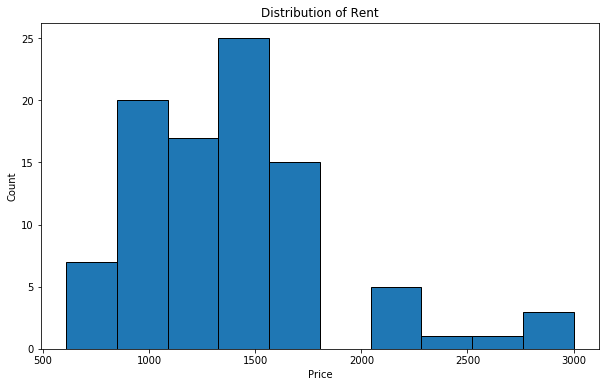

In [27]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(chicago_apts['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent");

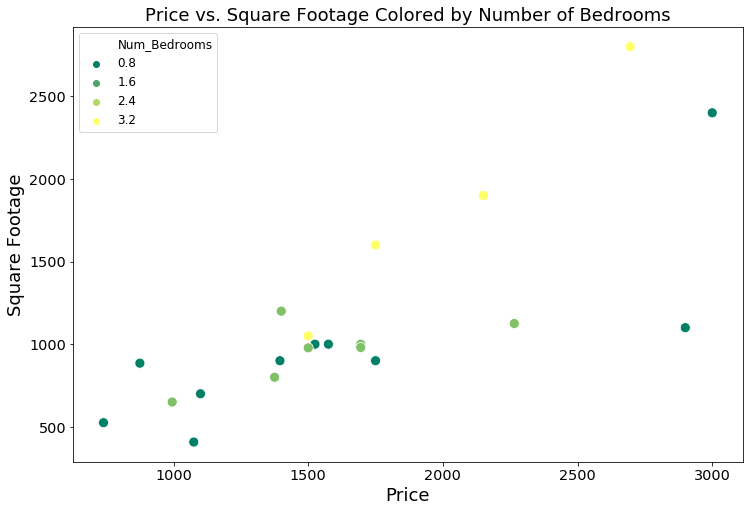

In [28]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=100, data=ch_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

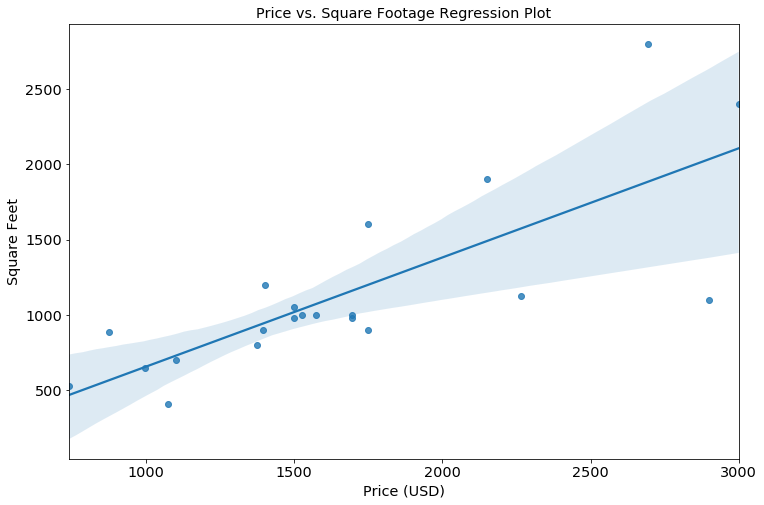

In [29]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=ch_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [30]:
#correlations of # of bedrooms, sqft and price
ch_apts.corr()

,Num_Bedrooms,Sqft,Price
Num_Bedrooms,1.000000,0.473636,0.423594
Sqft,0.473636,1.000000,0.774407
Price,0.423594,0.774407,1.000000


In [31]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
Andersonville,1.000000,NaN,1070.000000
Auburn Gresham,1.000000,525.0,740.000000
Bucktown,1.666667,980.0,1365.000000
Buena Park,NaN,NaN,850.000000
Chicago,1.833333,1089.0,1287.083333
Chicago & Lasalle,2.000000,1000.0,1695.000000
Chicago - Uptown,1.000000,NaN,950.000000
Chicago Prime Bridgeport,2.000000,650.0,995.000000
"Chicago, Illinois",1.000000,885.0,875.000000


In [32]:
#sort price to find cheapest
ch_apts.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
Midway Area                     610.000000
Auburn Gresham                  740.000000
South Shore                     800.000000
Buena Park                      850.000000
Chicago, Illinois               875.000000
North Kenwood                   895.000000
Chicago - Uptown                950.000000
Edgewater                       951.000000
Uptown                          973.333333
Chicago Prime Bridgeport        995.000000
Andersonville                  1070.000000
Glenview                       1100.000000
South Loop                     1170.000000
Pilsen                         1245.000000
Chicago                        1287.083333
Sheridan Park                  1292.000000
Bucktown                       1365.000000
Roscoe Village                 1395.000000
Lakeview                       1427.571429
Hyde Park                      1435.000000
Gold Coast                     1465.000000
Jefferson Park                 1475.000000
Evanston                       1507.50000

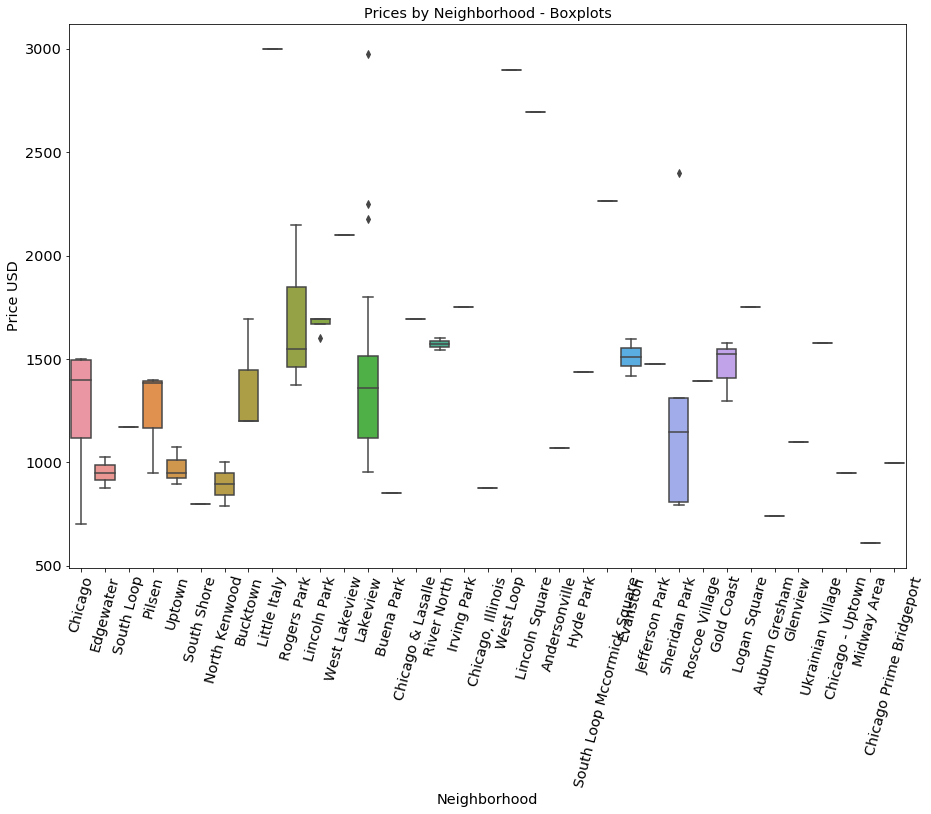

In [33]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=ch_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

In [34]:
############################
############################
# 1 bedroom apts
###########################
###########################
###########################

# get 5 most popular neighborhoods 
chicago_apts['Neighborhood'].value_counts()[:5].index.tolist()

#break it down and do a sns barplot below with the Neighborhood hue so you can compare those different areas
#sns.stripplot(data=chicago_apts, y="Price",x="Num_Bedrooms", jitter=True)
#sns.barplot(data=chicago_apts, y= "Price", x="Num_Bedrooms",hue="Neighborhood")

['Lakeview', 'Chicago', 'Sheridan Park', 'Lincoln Park', 'Gold Coast']

In [35]:
#Focusing on 1 bedroom apts
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns
chicago_apts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    94 non-null     int64  
 1   Posted        94 non-null     object 
 2   Neighborhood  94 non-null     object 
 3   Post_Title    94 non-null     object 
 4   Num_Bedrooms  82 non-null     float64
 5   Sqft          21 non-null     float64
 6   URL           94 non-null     object 
 7   Price         94 non-null     int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.0+ KB


(94, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

,Unnamed: 0,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,0,2020-12-08 12:56:00,Chicago,AVAILABLE NOW!!!!-3802 N SEELEY-2S 2 BED/ 1 BATH,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1500
1,1,2020-12-08 12:55:00,Edgewater,1 bedroom in Edgewater neighborhood 1ST MONTH ...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,875
2,2,2020-12-08 12:50:00,South Loop,"SOUTH LOOP! AMAZING LOFT STYLE Jr 1 bed WD, hd...",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1170
3,3,2020-12-08 12:50:00,Pilsen,RENOVATED Pilsen 1 Bed with in-unit washer/dryer,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400
4,4,2020-12-08 12:48:00,Chicago,AVAILABLE NOW!!!!-HOT SOUTHPORT CORRIDOR LOCAT...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1495


In [36]:
one = chicago_apts[chicago_apts.Num_Bedrooms.eq(1.0)]
one.shape

(47, 8)

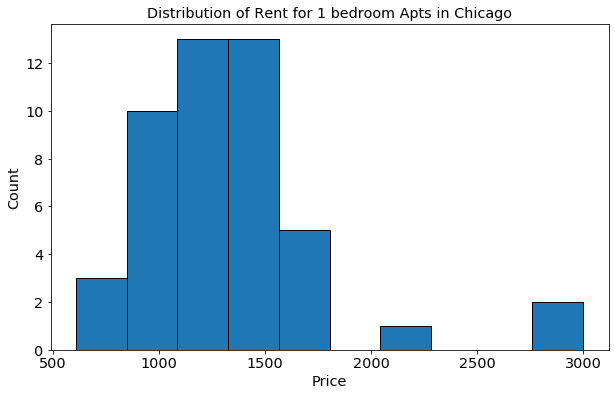

In [37]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(one['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent for 1 bedroom Apts in Chicago");

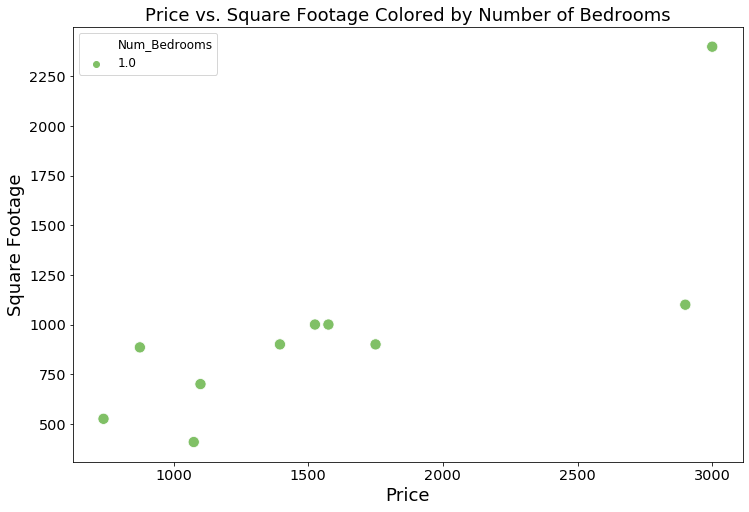

In [38]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=one.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

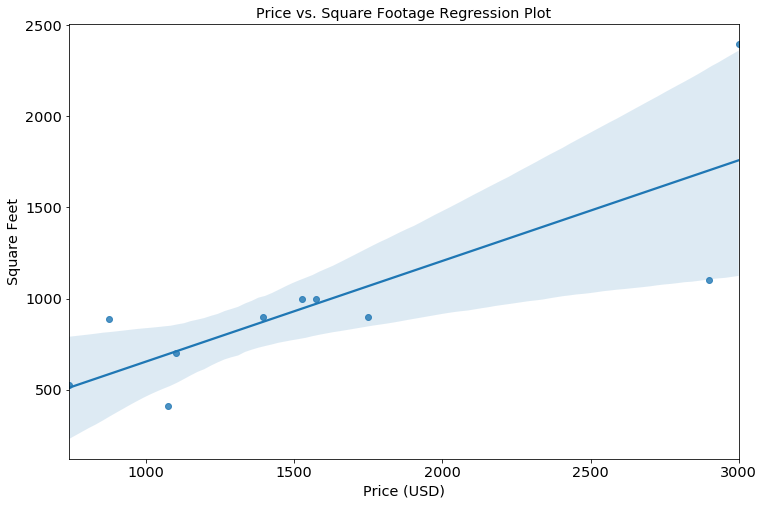

In [39]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=one.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [40]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
Andersonville,1.000000,NaN,1070.000000
Auburn Gresham,1.000000,525.0,740.000000
Bucktown,1.666667,980.0,1365.000000
Buena Park,NaN,NaN,850.000000
Chicago,1.833333,1089.0,1287.083333
Chicago & Lasalle,2.000000,1000.0,1695.000000
Chicago - Uptown,1.000000,NaN,950.000000
Chicago Prime Bridgeport,2.000000,650.0,995.000000
"Chicago, Illinois",1.000000,885.0,875.000000


In [41]:
#sort price to find cheapest
one.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
Midway Area           610.0
Auburn Gresham        740.0
South Shore           800.0
Chicago, Illinois     875.0
Chicago - Uptown      950.0
Edgewater             951.0
Uptown                985.0
North Kenwood        1000.0
Andersonville        1070.0
Glenview             1100.0
Sheridan Park        1145.0
South Loop           1170.0
Bucktown             1200.0
Chicago              1256.0
Lakeview             1376.8
Pilsen               1392.5
Roscoe Village       1395.0
Hyde Park            1435.0
Gold Coast           1465.0
River North          1571.0
Lincoln Park         1600.0
Logan Square         1750.0
West Loop            2900.0
Little Italy         3000.0
Name: Price, dtype: float64

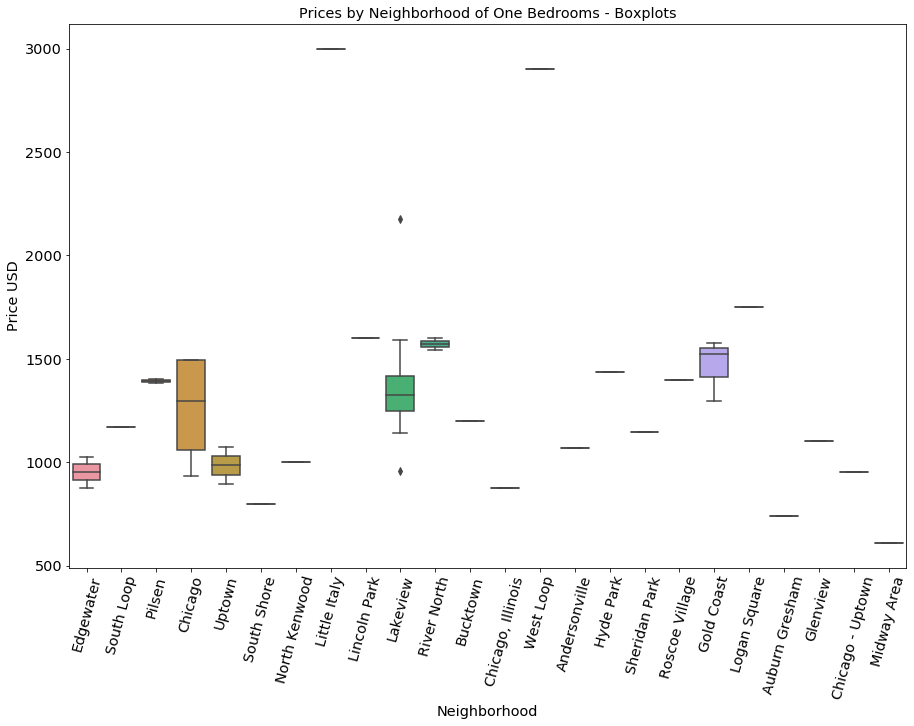

In [43]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=one)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood of One Bedrooms - Boxplots");